In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas_datareader import DataReader


import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
#from keras.layers import *
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import yfinance as yf

In [122]:
# Считаем данные
start = '2014-01-01'
end = '2024-10-01'
symbol = 'SHEL'
company = 'SHELL'
stock_data = yf.Ticker(symbol)
stock_data = stock_data.history(start=start, end=end)

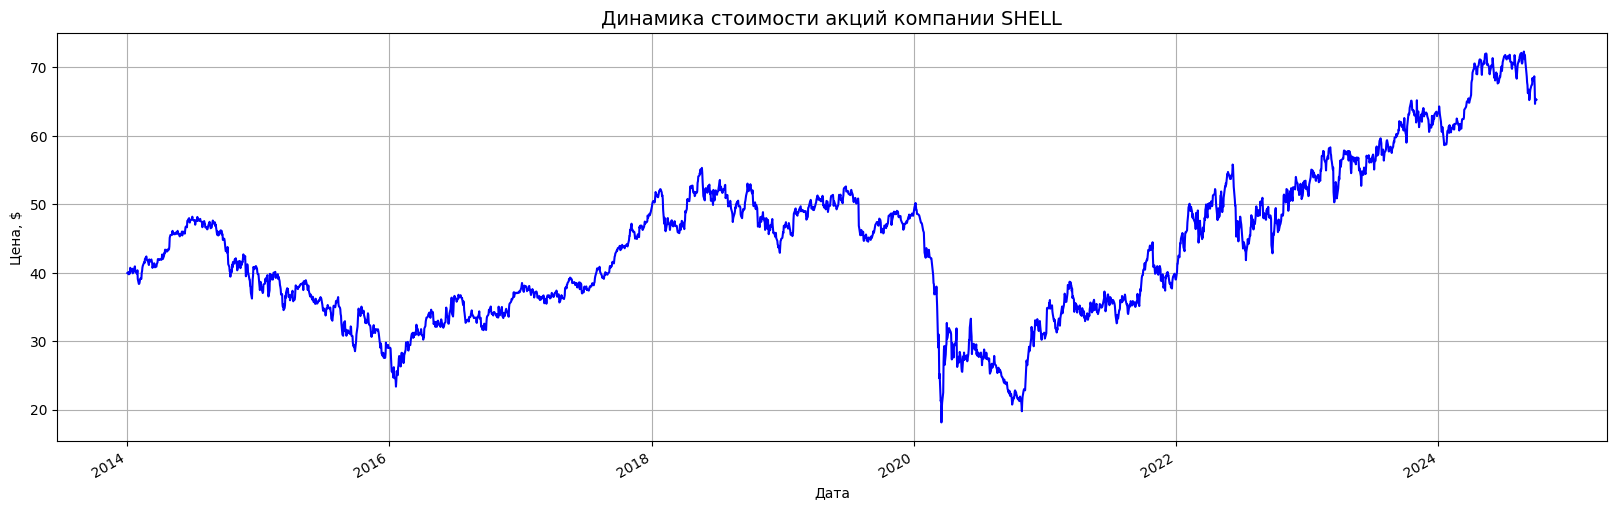

In [123]:
stock_data['Close'].plot(color = 'blue', figsize=(20, 6))
plt.title('Динамика стоимости акций компании '+company, fontsize = 14)
plt.xlabel('Дата')
plt.ylabel('Цена, $')
#plt.legend(loc = 'best')
plt.grid()
plt.show()

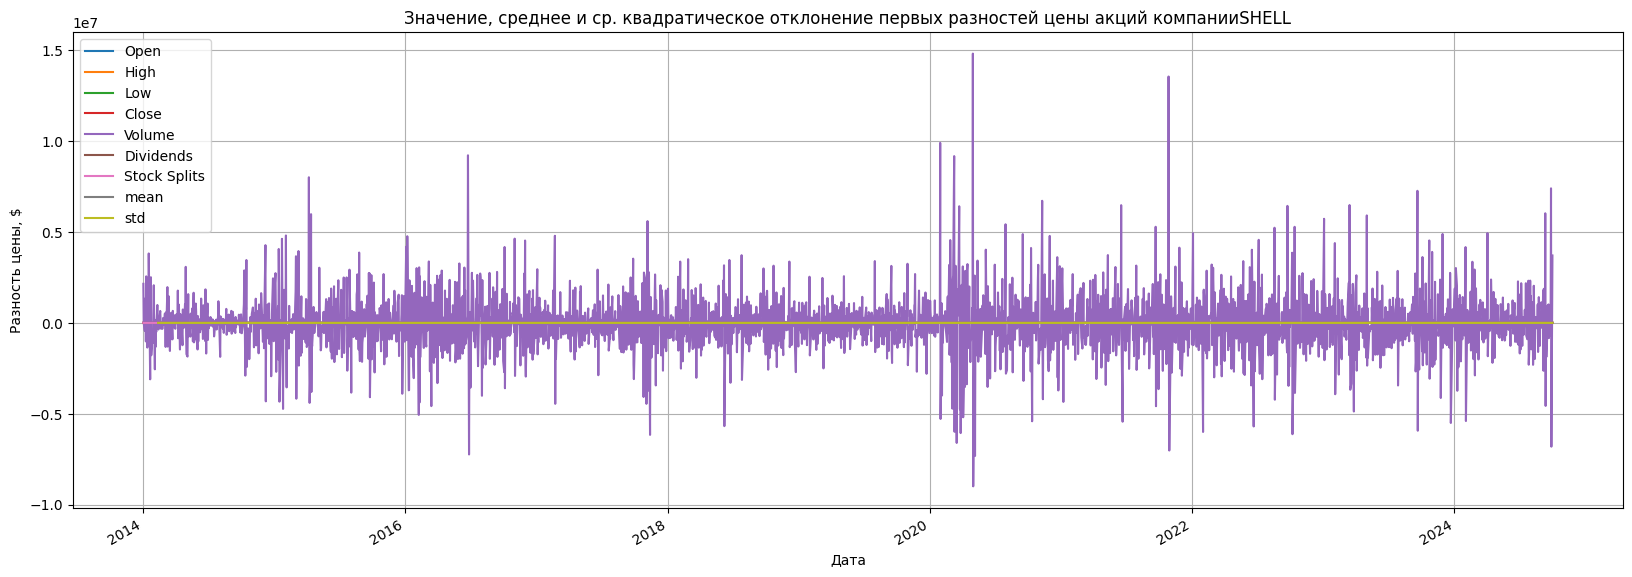

In [124]:
df_shift = stock_data - stock_data.shift(fill_value=0)

df_shift['mean'] = df_shift['Close'].shift().rolling(28).mean()
df_shift['std'] = df_shift['Close'].shift().rolling(28).std()

df_shift.plot(figsize = (20, 7))
plt.title('Значение, среднее и ср. квадратическое отклонение первых разностей цены акций компании' +company)
plt.xlabel('Дата')
plt.ylabel('Разность цены, $')
plt.grid()
plt.show()

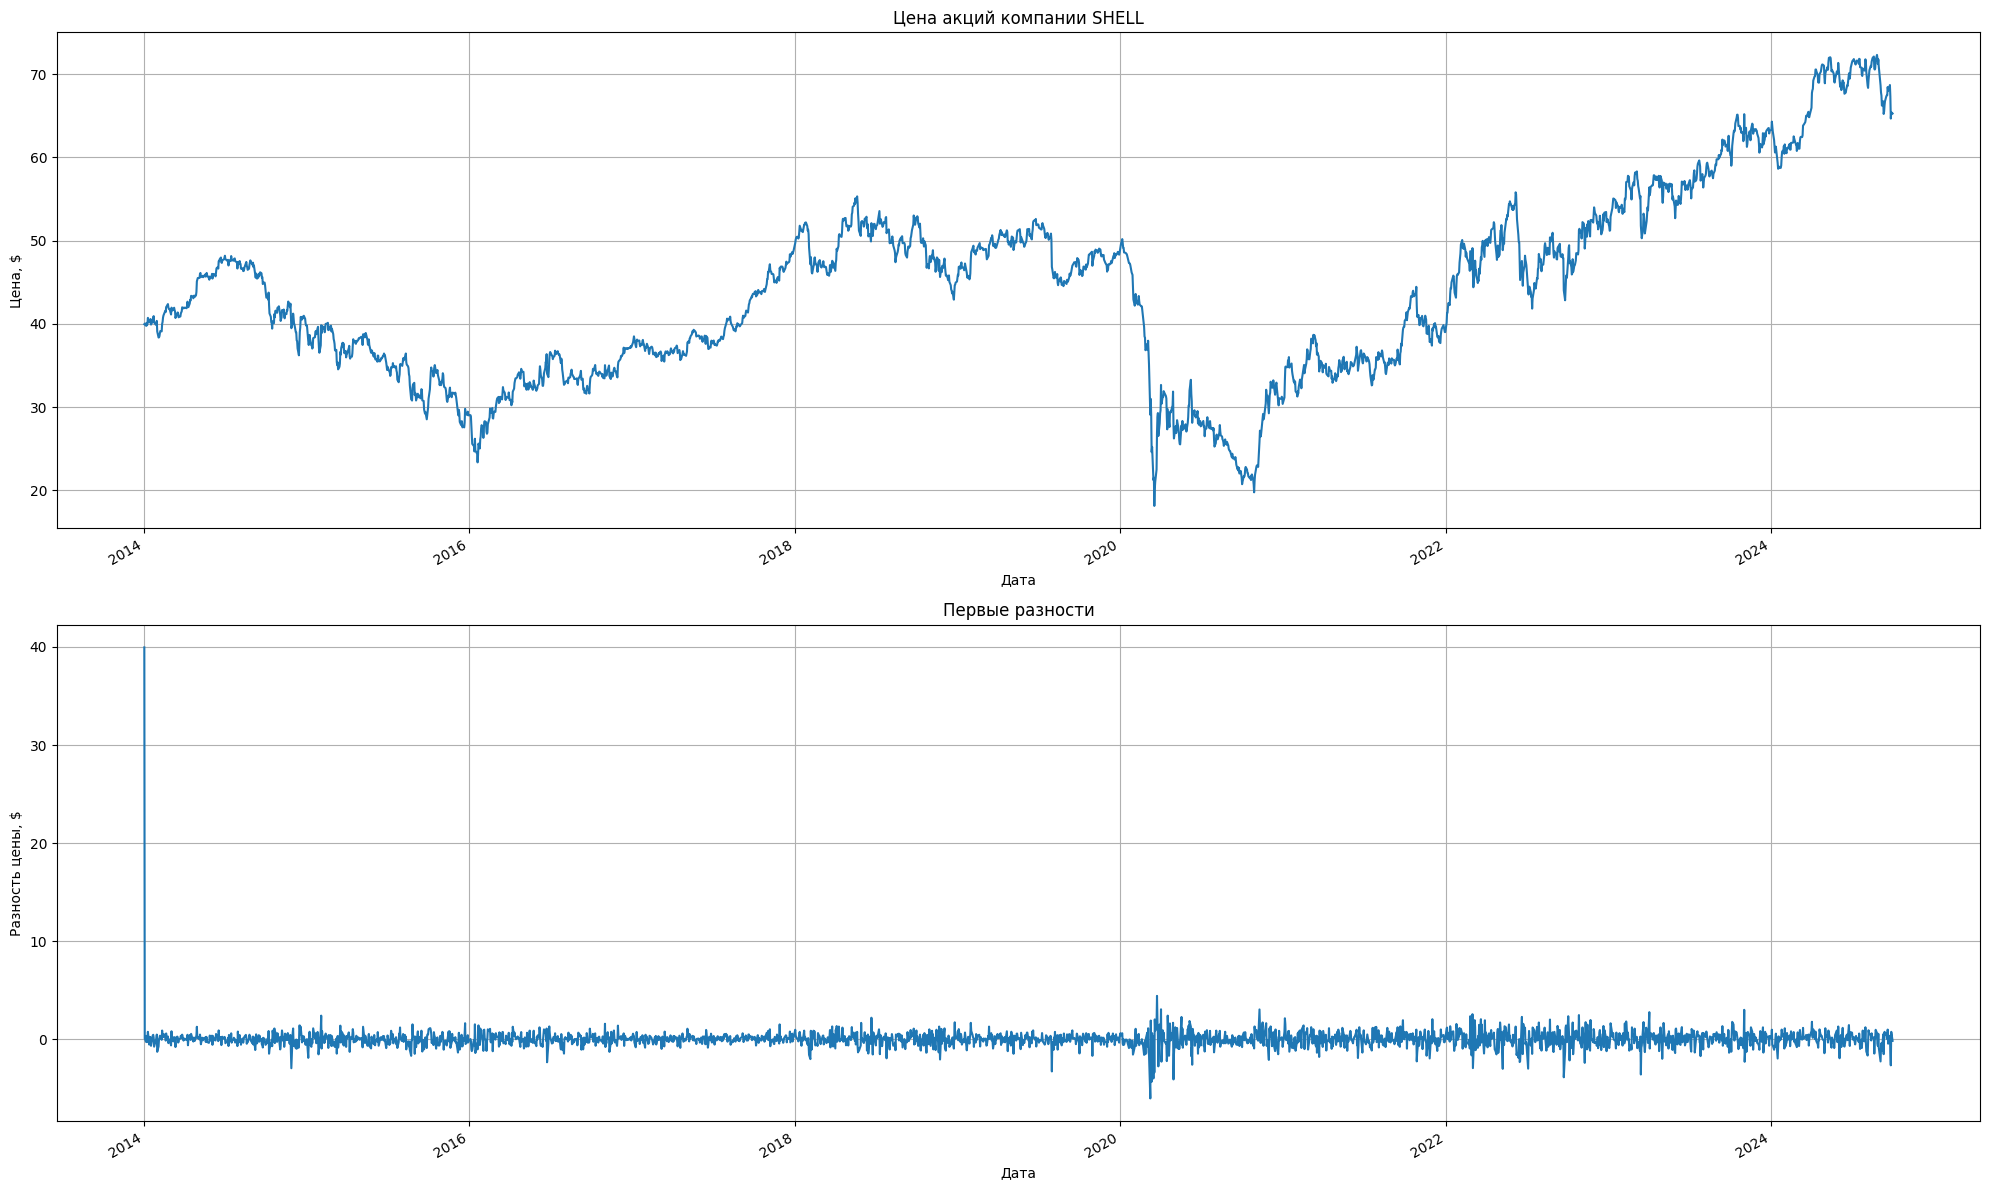

In [125]:
# Построим график исходного временного ряда и ряд его первых разностей
plt.figure(figsize=(20, 12))
plt.subplot(211)
stock_data['Close'].plot(ax = plt.gca())
plt.title('Цена акций компании '+company)
plt.xlabel('Дата')
plt.ylabel('Цена, $')
plt.grid()

plt.subplot(212)
df_shift['Close'].plot(ax = plt.gca())
plt.title('Первые разности')
plt.xlabel('Дата')
plt.ylabel('Разность цены, $')
plt.grid()

plt.tight_layout()

<Figure size 1200x700 with 0 Axes>

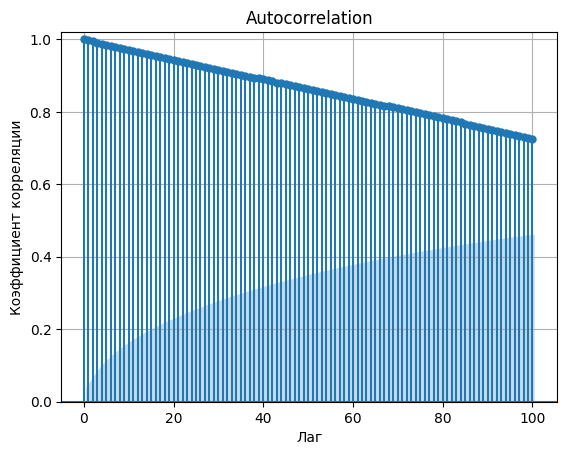

In [126]:
plt.figure(figsize=(12, 7))
plot_acf(stock_data['Close'], lags = 100)
plt.xlabel('Лаг')
plt.ylabel('Коэффициент корреляции')
plt.ylim([0, 1.02])
plt.grid()
plt.show()

In [127]:
test = adfuller(stock_data['Close'], regression = 'ct')
print('adf:',test[0])
print('p-value:',test[1])
print('critical values:',test[4])

if test[0]> test[4]['1%']:
    print('есть единичные корни, ряд не стационарен при 1% уровне значимости')
else:
    print('единичных корней нет, ряд стационарен при 1% уровне значимости')

if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен при 5% уровне значимости')
else:
    print('единичных корней нет, ряд стационарен при 5% уровне значимости')

if test[0]> test[4]['10%']:
    print('есть единичные корни, ряд не стационарен при 10% уровне значимости')
else:
    print('единичных корней нет, ряд стационарен при 10% уровне значимости')

adf: -1.9275997965002787
p-value: 0.640249698692392
critical values: {'1%': -3.962123176309614, '5%': -3.412115508384243, '10%': -3.128007105125201}
есть единичные корни, ряд не стационарен при 1% уровне значимости
есть единичные корни, ряд не стационарен при 5% уровне значимости
есть единичные корни, ряд не стационарен при 10% уровне значимости


In [128]:
stock_data.reset_index(inplace = True)
stock_data['Date']= pd.to_datetime(stock_data['Date']).dt.date


In [129]:
#Data Preprocessing

num_shape = 2400

train = stock_data.iloc[:num_shape, 1:2].values
test = stock_data.iloc[num_shape:, 1:2].values

In [130]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train)


In [131]:
X_train = []

# Цена на следующий день
y_train = []

# Выбираем ширину окна, т.е. длину входного вектора
window = 30

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)
X_train.shape

(2370, 30, 1)

In [132]:
# Initializing the Recurrent Neural Network
model = tensorflow.keras.Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 36, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 36, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 36, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 30, 36)         │         5,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 30, 36)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 30, 36)         │        10,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 30, 36)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 30, 36)         │        10,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 30, 36)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,947 (171.67 KB)

 Trainable params: 43,947 (171.67 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=10)

In [134]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

hist = model.fit(X_train, y_train, epochs = 40, batch_size = 64, verbose = 1)#, validation_split = 0.20, callbacks = [early_stop]);

#2.4

Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.1262 - mae: 0.2760
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0110 - mae: 0.0823
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0085 - mae: 0.0706
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0076 - mae: 0.0665
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0069 - mae: 0.0643
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0064 - mae: 0.0620
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0069 - mae: 0.0628
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0072 - mae: 0.0653
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0069 - mae: 0.0654
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0054 - mae: 0.0562
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0054 - mae: 0.0560
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0065 - mae: 0.0617
Epoch 13/40
38/38 ━━━━━━━━━━━━━━━━━━━

In [135]:
#
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)

X_test = np.stack(X_test)

In [136]:
predict_LSTM = model.predict(X_test)
predict_LSTM = scaler.inverse_transform(predict_LSTM)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


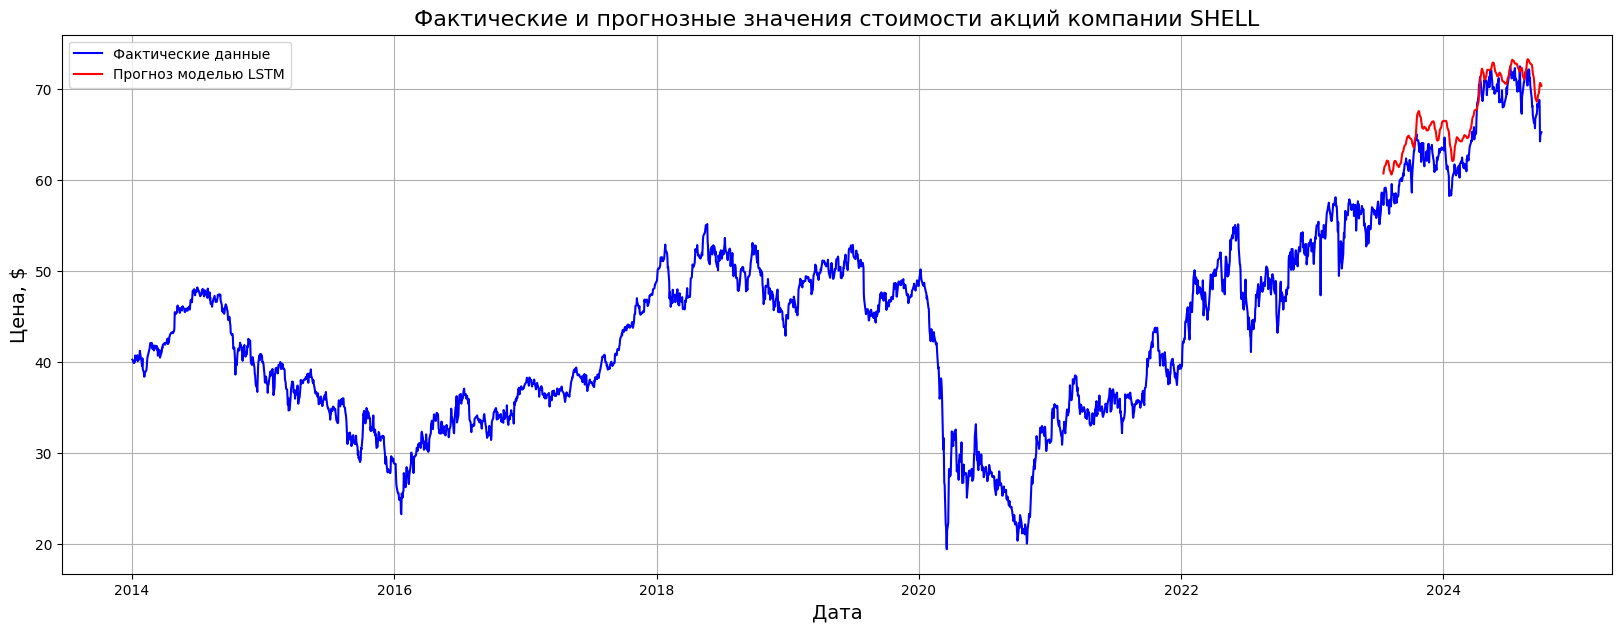

In [137]:
plt.figure(figsize=(20,7))
plt.plot(stock_data['Date'].values, df_volume, color = 'blue', label='Фактические данные')
plt.plot(stock_data['Date'][-predict_LSTM.shape[0]:].values, predict_LSTM+4, color = 'red', label='Прогноз моделью LSTM')
plt.legend()
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Цена, $', fontsize = 14)
plt.grid()
plt.title('Фактические и прогнозные значения стоимости акций компании '+company, fontsize = 16)
plt.show()

In [138]:
# Прогноз на 5 дней вперед

horizon = 5
pred_ = predict_LSTM[-1].copy()
prediction_full = []
df_copy = stock_data.iloc[:, 1:2][1:].values

for j in range(horizon):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]

    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = scaler.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = scaler.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

# 0.34

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [139]:
prediction_full_new = np.vstack((predict_LSTM, np.array(prediction_full).reshape(-1,1)))

In [140]:
# Формируем столбец с новыми датами
df_date = stock_data[['Date']]

for h in range(horizon):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add], columns=['Date'])
    df_date = pd.concat([df_date, df_date_add], axis = 0)
df_date = df_date.reset_index(drop=True)

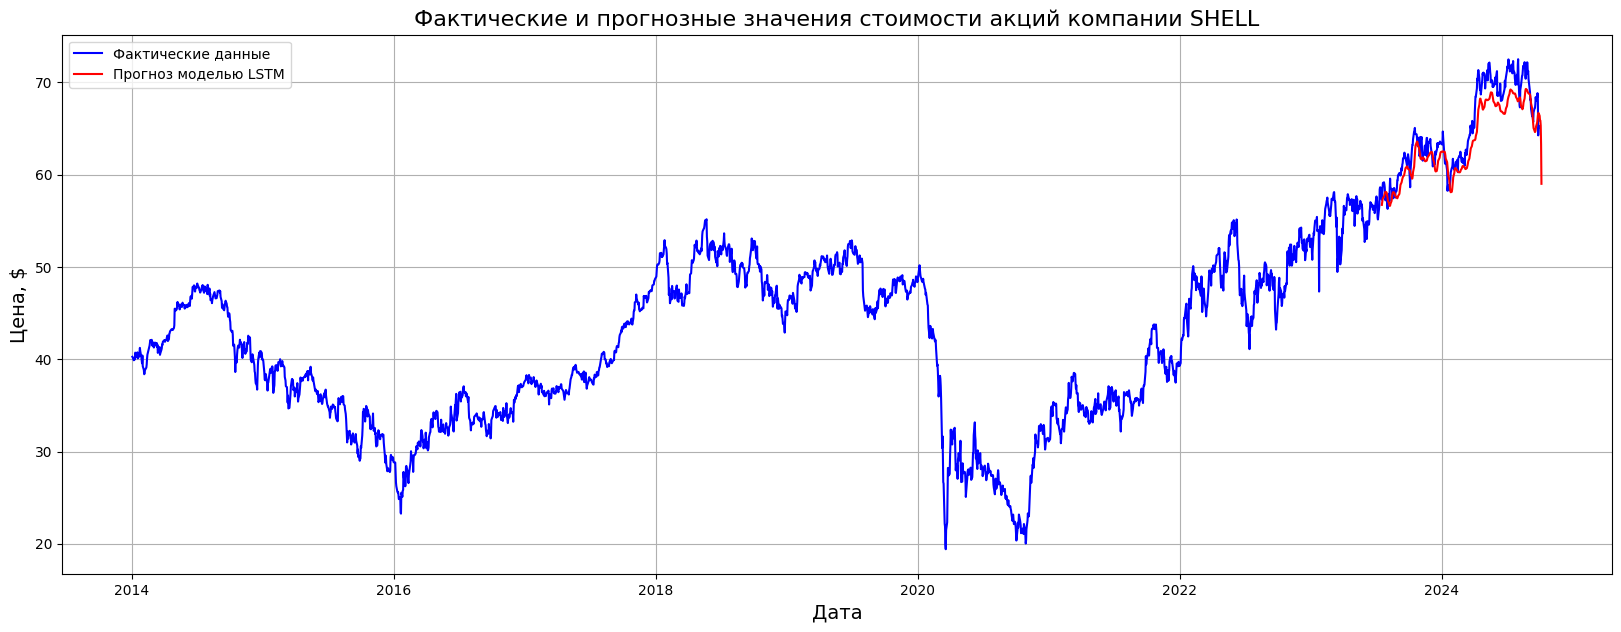

In [141]:
# Построим графики фактических данных и результатов прогноза для тестовой выборки
plt.figure(figsize=(20,7))
plt.plot(stock_data['Date'].values, df_volume, color = 'blue', label='Фактические данные')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'red', label='Прогноз моделью LSTM')
plt.legend()
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Цена, $', fontsize = 14)
plt.grid()
plt.title('Фактические и прогнозные значения стоимости акций компании '+company, fontsize = 16)
plt.show()

In [142]:
# # Initializing the Recurrent Neural Network
# model_GRU = tensorflow.keras.Sequential()
# #Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
# #Units - dimensionality of the output space

# model_GRU.add(GRU(units = 36, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# model_GRU.add(Dropout(0.2))

# model_GRU.add(GRU(units = 36, return_sequences = True))
# model_GRU.add(Dropout(0.2))

# model_GRU.add(GRU(units = 36, return_sequences = True))
# model_GRU.add(Dropout(0.2))

# model_GRU.add(GRU(units = 50))
# model_GRU.add(Dropout(0.2))

# # Adding the output layer
# model_GRU.add(Dense(units = 1))
# model_GRU.summary()

In [143]:
# Архитектура GRU
model_GRU = tensorflow.keras.Sequential()
# Первый слой GRU
model_GRU.add(GRU(units=50, return_sequences=True,
input_shape=(X_train.shape[1],1), activation='tanh'))
model_GRU.add(Dropout(0.2))
# Второй слой GRU
model_GRU.add(GRU(units=50, return_sequences=True,
input_shape=(X_train.shape[1],1), activation='tanh'))
model_GRU.add(Dropout(0.2))
# Третий слой GRU
model_GRU.add(GRU(units=50, return_sequences=True,
input_shape=(X_train.shape[1],1), activation='tanh'))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units=50, activation='tanh'))
model_GRU.add(Dropout(0.2))
# Выходной слой
model_GRU.add(Dense(units=1))


# Создание RNN сети
model_GRU.compile(optimizer=SGD(decay=1e-7, momentum=0.9,nesterov=False),loss='mean_squared_error')



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [144]:
model_GRU.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

hist = model_GRU.fit(X_train, y_train, epochs = 40, batch_size = 64, verbose = 1)#, validation_split = 0.20, callbacks = [early_stop]);

#2.4

Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.1137 - mae: 0.2556
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0088 - mae: 0.0730
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0063 - mae: 0.0614
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0053 - mae: 0.0555
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0051 - mae: 0.0547
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0053 - mae: 0.0562
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0050 - mae: 0.0532
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0040 - mae: 0.0482
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0047 - mae: 0.0521
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0051 - mae: 0.0545
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0045 - mae: 0.0520
Epoch 12/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0036 - mae: 0.0456
Epoch 13/40
38/38 ━━━━━━━━━━━━━━━━━━

In [145]:
predict_GRU = model_GRU.predict(X_test)
predict_GRU = scaler.inverse_transform(predict_GRU)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step


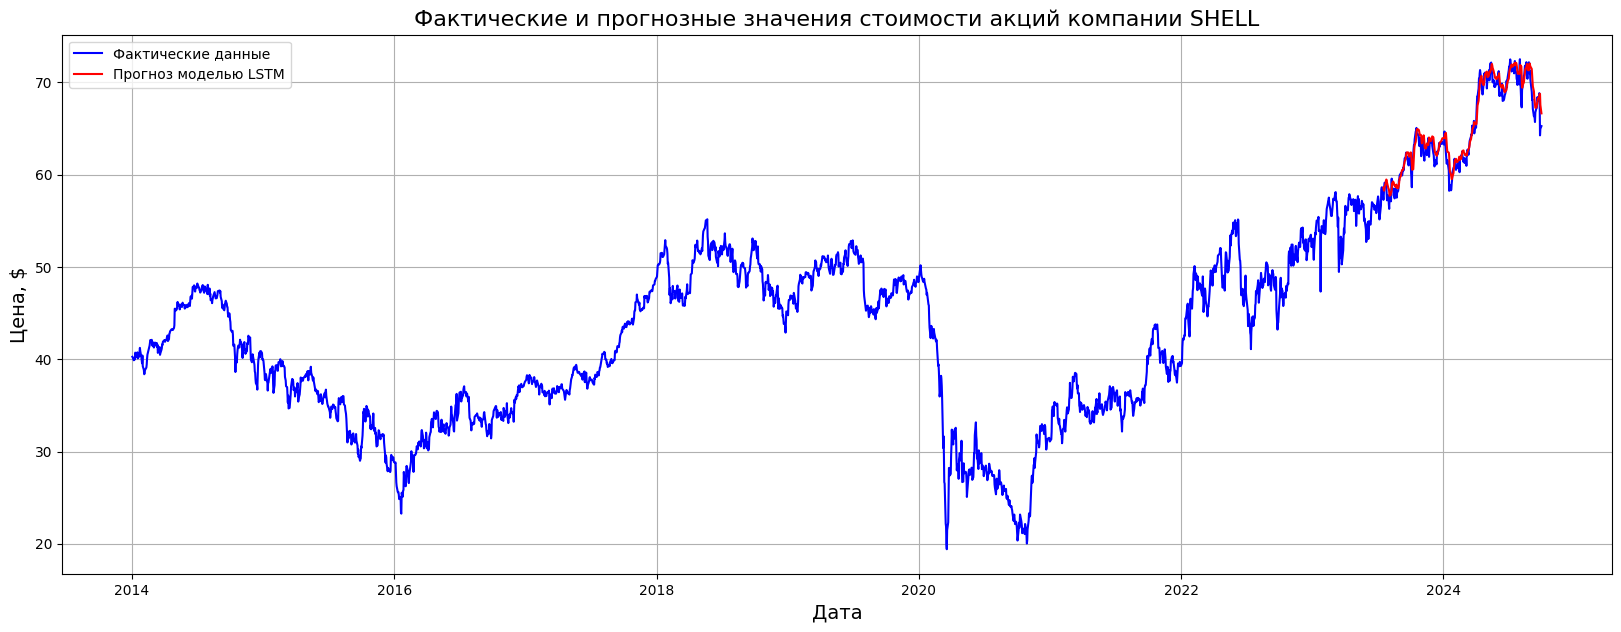

In [146]:
plt.figure(figsize=(20,7))
plt.plot(stock_data['Date'].values, df_volume, color = 'blue', label='Фактические данные')
plt.plot(stock_data['Date'][-predict_GRU.shape[0]:].values, predict_GRU, color = 'red', label='Прогноз моделью LSTM')
plt.legend()
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Цена, $', fontsize = 14)
plt.grid()
plt.title('Фактические и прогнозные значения стоимости акций компании '+company, fontsize = 16)
plt.show()

In [156]:
def return_rmse(true_values, predicted_values):
    return np.sqrt(mean_squared_error(true_values, predicted_values))


predict_GRU = model_GRU.predict(X_test)
predict_GRU = scaler.inverse_transform(predict_GRU)

rmse = return_rmse(df_volume[-304:], predict_GRU)
print(f"RMSE: {rmse:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE: 1.0993


In [157]:
def return_rmse(true_values, predicted_values):
    return np.sqrt(mean_squared_error(true_values, predicted_values))


predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

rmse = return_rmse(df_volume[-304:], predicted_stock_price)
print(f"RMSE: {rmse:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 2.0958
